# Pix2Pix
입력 자체가 조건이 된다면 어떨까?  
cGAN은 클래스 레이블 등의 조건을 함께 입력해주었는데 더 나아가 내가 원하는 이미지를 얻기 위해 이미지를 조건으로 주려고 할 때 Pix2Pix를 생각해볼 수 있다. Pix2Pix는 기존 노이즈 입력을 이미지로 변환하는 일반적인 GAN이 아니라, **이미지를 입력으로 하여 원하는 다른 형태의 이미지로 변환**시킬 수 있는 GAN모델이다.  

예를들면 흑백사진을 컬러로 변환하거나 스케치된 그림에 색상을 입힌다거나 위성사진을 간단히 표현할 수도 있다.  

<br>

cGAN은 fully-connected layer를 연속적으로 쌓아 만들었지만, 이미지 변환이 목적인 Pix2Pix는 이미지를 다루는데 효율적인 **convolution layer를 활용**한다. 또한 GAN 구조를 기반으로 하기 때문에 크게 **Generator**와 **Discriminator** 두 가지 구성 요소로 이루어진다.

### Generator
- 이미지를 입력받아 변환된 이미지를 출력하기 위해 사용된다.
- 입력이미지와 변환된 이미지 크기는 동일해야하고, Encoder-Decoder구조를 사용한다.

### Discriminator
- 하나의 이미지가 Discriminator의 입력으로 들어오면, convolution 레이어를 거쳐 확률값을 나타내는 최종 결과를 생성하는데, 그 결과는 하나의 값이 아닌 여러 개의 값을 갖는다.
- 즉, 일부 영역에 대해서만 진짜/가짜를 판별하는 하나의 확률값을 도출한다는 것이다.
- 이 값들을 평균하여 최종 Discriminator의 출력을 생성한다.
- 이러한 방법은 이미지의 일부 영역(patch)을 이용한다고 하여 **PatchGAN**이라고 불린다.
- 일반적으로 이미지에서 **거리가 먼 두 픽셀은 서로 연관성이 없기 때문에** 특정 크기를 가진 일부 영역에 대해서 세부적으로 진짜/가짜를 판별하는 것이 Generator로 하여금 더 진짜 같은 이미지를 만들도록 하는 방법이다.

<br><br><br><br>

# 1. 데이터 준비
`$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/sketch2pokemon.zip`  
`$ mv sketch2pokemon.zip ~/aiffel/conditional_generation`  
`$ cd ~/aiffel/conditional_generation && unzip sketch2pokemon.zip`  

In [34]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation
from tensorflow import data
from tensorflow.keras import layers, Input, Model
from tensorflow.keras import losses
from tensorflow.keras import optimizers

number of train examples : 830


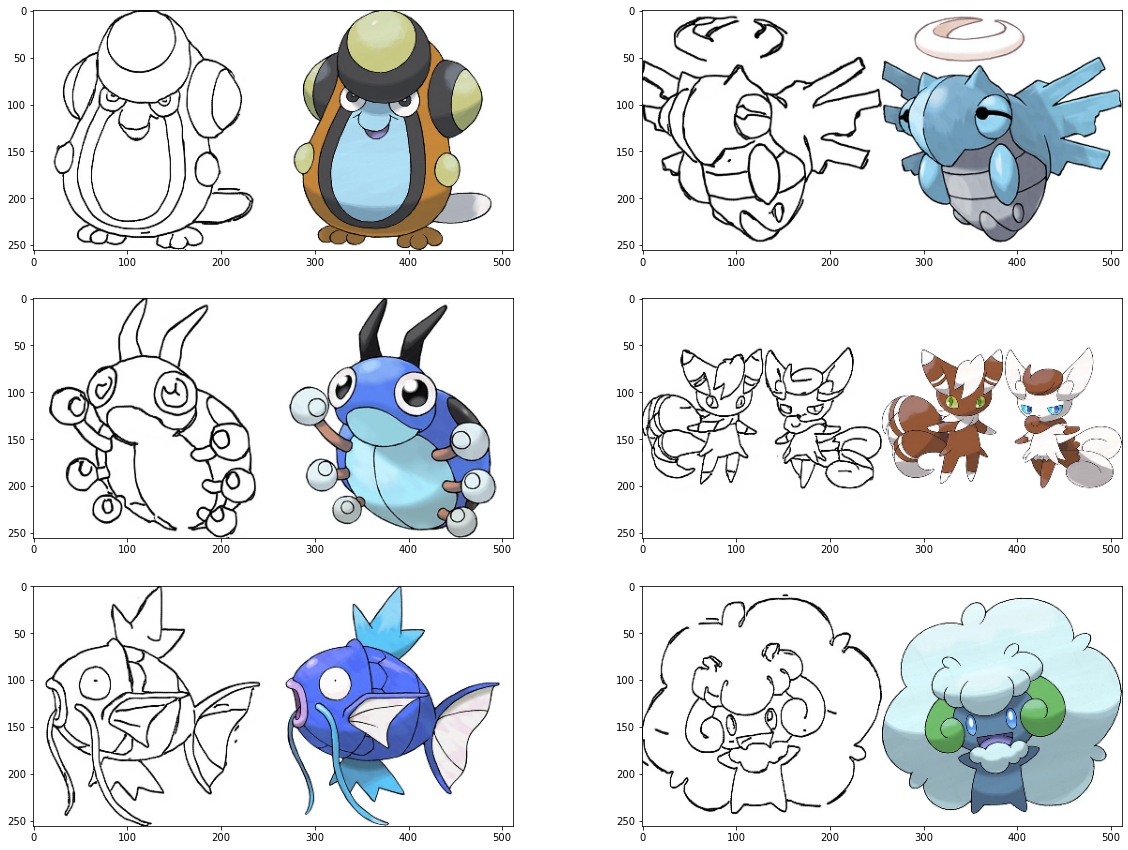

In [5]:
data_path = os.getenv('HOME')+'/aiffel/conditional_generation/pokemon_pix2pix_dataset/train/'
print("number of train examples :", len(os.listdir(data_path)))

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [3]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print(img.shape)

(256, 512, 3)


2개의 이미지로 분할하여 사용

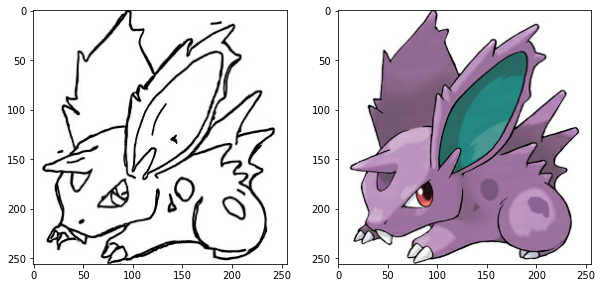

In [6]:
# 정규화
def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

  # 비정규화
def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    w = tf.shape(img)[1] // 2
    sketch = img[:, :w, :] 
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, w:, :] 
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch))
plt.subplot(1,2,2); plt.imshow(denormalize(colored))

데이터 수가 830개 밖에 되지 않으므로, 데이터의 다양성을 높이기 위해 여러 **augmentation** 방법 적용  
1. sketch, colored 이미지를 채널축으로 연결한다. 두 이미지가 각각 3채널인 경우 6채널이 된다.
2. 1번 이미지에 제로패딩을 적용한다.
3. 2번 이미지의 특정부분을 랜덤으로 자른다.(256,256,6)
4. 3번 이미지를 1/2확률로 좌우 뒤집는다.
5. 4번 이미지를 1/2확률로 상하 뒤집는다.
6. 만약 랜덤값이 0.5이하라면 5번이미지에 시계 반대 방향으로 90도 회전시켜준다.

In [7]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1)
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5:  # tf.random.uniform(()) : 0과 1사이의 랜덤값을 만듬, shape=()
        padded = tf.pad(stacked, _pad, "REFLECT")  # 이미지에 제로패딩 적용
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)

    out = image.random_crop(padded, size=[256, 256, 6])
    
    out = image.random_flip_left_right(out)
    out = image.random_flip_up_down(out)
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32)
        out = image.rot90(out, k=degree)
    
    return out[...,:3], out[...,3:]   

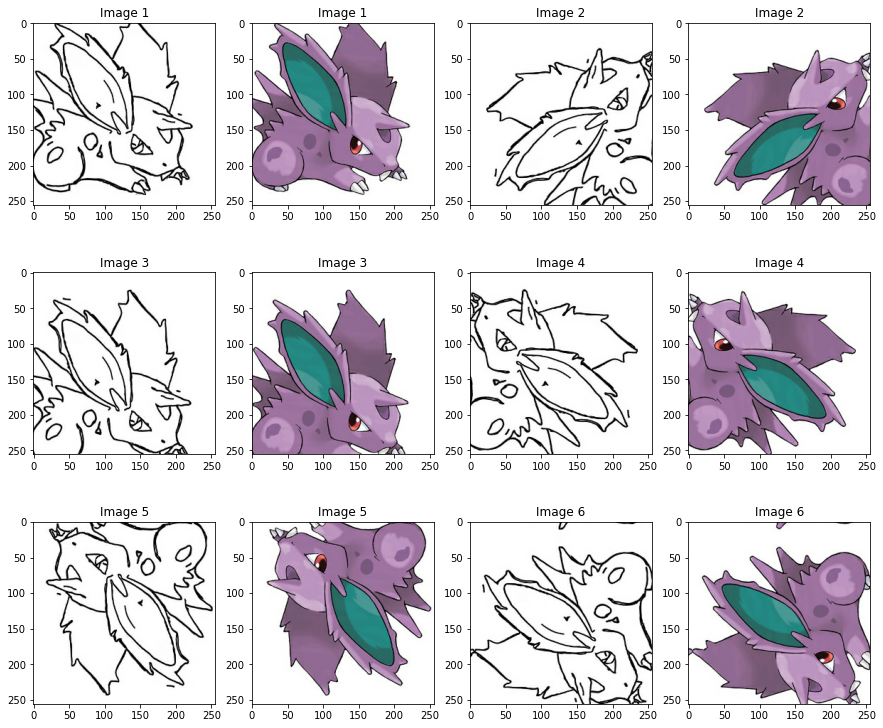

In [8]:
plt.figure(figsize=(15,13))
img_n = 1
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

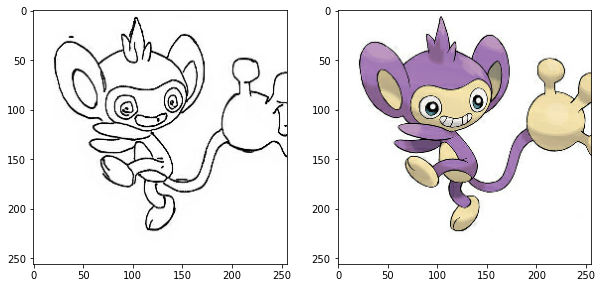

In [9]:
def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

<br><br><br><br>

# 2. Generator 구성
- encoder, decoder 구성
- Convolution 레이어에서 필터의 크기(=4) 및 stride(=2)와 LeakyReLU 활성화의 slope coefficient(=0.2)는 모든 곳에서 고정되어 사용하므로 각각의 값을 지정

## 2-1. Encoder

In [12]:
# n_filters : 사용한 필터의 개수
# use_bn : BatchNorm 사용 여부
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [13]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64, 128, 256, 512, 512, 512, 512, 512]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [14]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encode_block (EncodeBlock)   (None, 128, 128, 64)      3072      
_________________________________________________________________
encode_block_1 (EncodeBlock) (None, 64, 64, 128)       131584    
_________________________________________________________________
encode_block_2 (EncodeBlock) (None, 32, 32, 256)       525312    
_________________________________________________________________
encode_block_3 (EncodeBlock) (None, 16, 16, 512)       2099200   
_________________________________________________________________
encode_block_4 (EncodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
encode_block_5 (EncodeBlock) (None, 4, 4, 512)         419635

## 2-2. Decoder

In [15]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

In [16]:
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,256)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [17]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 1, 1, 256)]       0         
_________________________________________________________________
decode_block (DecodeBlock)   (None, 2, 2, 512)         2099200   
_________________________________________________________________
decode_block_1 (DecodeBlock) (None, 4, 4, 512)         4196352   
_________________________________________________________________
decode_block_2 (DecodeBlock) (None, 8, 8, 512)         4196352   
_________________________________________________________________
decode_block_3 (DecodeBlock) (None, 16, 16, 512)       4196352   
_________________________________________________________________
decode_block_4 (DecodeBlock) (None, 32, 32, 256)       2098176   
_________________________________________________________________
decode_block_5 (DecodeBlock) (None, 64, 64, 128)       5248

## 2-3. Encoder, Decoder 연결

In [18]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [19]:
EncoderDecoderGenerator().get_summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
encoder_1 (Encoder)          (None, 1, 1, 512)         19544576  
_________________________________________________________________
decoder_1 (Decoder)          (None, 256, 256, 3)       19542784  
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


<br><br><br><br>

# 3. Generator 재구성
2번 단계에서 구현했던 Generator는 기본 Encoder-Decoder구조이다. Pix2Pix는 Encoder, Decoder 사이를 skip connection으로 연결한 **U-Net** 구조를 사용한다.

In [20]:
class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu = layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

In [21]:
class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)

- EncodeBlock, DecodeBlock은 수정한 것 없다.
- UNetGenerator
  - `__init__()`에서 Encoder, Decoder에서 사용할 모든 블록들 정의
  - `call()`에서 forward propagation하고, skip connection을 구현하였다.
  - Encoder와 Decoder 사이의 skip connection을 위해 features 라는 리스트를 만들고 Encoder 내에서 사용된 각 블록들의 출력을 차례대로 담았다.
  - 이후 Encoder의 최종 출력이 Decoder의 입력으로 들어가면서 다시 한번 각각의 Decoder 블록들을 통과하는데, features리스트에 있는 각각의 출력들이 Decoder블록 연산 후 함께 연결되어 다음 블록의 입력으로 사용된다.

In [23]:
class UNetGenerator(Model):
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)
        
        features = features[:-1]  # Encoder의 마지막 출력은 Decoder로 직접 입력되므로 skip connection의 대상이 아니므로 [:-1]을 해준다.
                    
        for block, feat in zip(self.decode_blocks, features[::-1]):
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

In [24]:
UNetGenerator().get_summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
encode_block_16 (EncodeBlock)   (None, 128, 128, 64) 3072        input_4[0][0]                    
__________________________________________________________________________________________________
encode_block_17 (EncodeBlock)   (None, 64, 64, 128)  131584      encode_block_16[0][0]            
__________________________________________________________________________________________________
encode_block_18 (EncodeBlock)   (None, 32, 32, 256)  525312      encode_block_17[0][0]            
____________________________________________________________________________________________

<br><br><br><br>

# 4. Discriminator 구성
- 70x70 PatchGAN 사용
- 최종 출력 크기가 (30,30)이 되어야 하는 이유는 앞서 Discriminator에 대해 알아봤던 70x70 PatchGAN을 사용했기 때문이다. 최종 (30,30) 출력에서 각 픽셀의 receptive field 크기를 (70,70)으로 맞추기 위해 Discriminator의 출력 크기를 (30,30) 크기로 강제로 맞추는 과정이다.

In [26]:
# n_filters: 필터 수
# stride : 필터가 순회하는 간격
# custom_pad : 출력 feature map의 크기를 조절할 수 있도록 하는 패딩 설정
# use_bn : BatchNorm의 사용 여부
# act : 활성화 함수 사용 여부
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 

In [28]:
# 출력 크기 확인
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 128, 128, 32)]    0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 130, 130, 32)      0         
_________________________________________________________________
conv2d_24 (Conv2D)           (None, 127, 127, 64)      32768     
_________________________________________________________________
batch_normalization_45 (Batc (None, 127, 127, 64)      256       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 127, 127, 64)      0         
Total params: 33,024
Trainable params: 32,896
Non-trainable params: 128
_________________________________________________________________


In [29]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y])
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()

In [30]:
Discriminator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concatenate_7 (Concatenate)     (None, 256, 256, 6)  0           input_6[0][0]                    
                                                                 input_7[0][0]                    
__________________________________________________________________________________________________
disc_block (DiscBlock)          (None, 128, 128, 64) 6144        concatenate_7[0][0]        

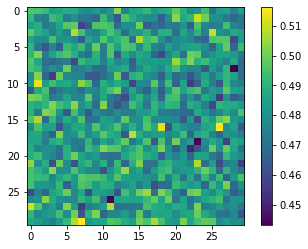

In [31]:
# test visualization
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

<br><br><br><br>

# 5. 학습

In [33]:
bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)

In [36]:
# optimizer 설정
gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)

In [37]:
# 하나의 배치 크기만큼 데이터를 입력했을 때 가중치를 1회 업데이트하는 과정
@tf.function
def train_step(sketch, real_colored):
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape:
        # Generator 예측
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (100 * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables)
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables))
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables))
    return gene_loss, l1_loss, disc_loss

In [38]:
EPOCHS = 10

generator = UNetGenerator()
discriminator = Discriminator()

for epoch in range(1, EPOCHS+1):
    for i, (sketch, colored) in enumerate(train_images):
        g_loss, l1_loss, d_loss = train_step(sketch, colored)
                
        # 10회 반복마다 손실을 출력합니다.
        if (i+1) % 10 == 0:
            print(f"EPOCH[{epoch}] - STEP[{i+1}] \
                    \nGenerator_loss:{g_loss.numpy():.4f} \
                    \nL1_loss:{l1_loss.numpy():.4f} \
                    \nDiscriminator_loss:{d_loss.numpy():.4f}", end="\n\n")

EPOCH[1] - STEP[10]                     
Generator_loss:1.0084                     
L1_loss:0.5129                     
Discriminator_loss:1.1847

EPOCH[1] - STEP[20]                     
Generator_loss:0.8471                     
L1_loss:0.2951                     
Discriminator_loss:1.2926

EPOCH[1] - STEP[30]                     
Generator_loss:0.9289                     
L1_loss:0.2253                     
Discriminator_loss:1.1101

EPOCH[1] - STEP[40]                     
Generator_loss:1.5840                     
L1_loss:0.2278                     
Discriminator_loss:1.2655

EPOCH[1] - STEP[50]                     
Generator_loss:0.8273                     
L1_loss:0.2935                     
Discriminator_loss:0.9806

EPOCH[1] - STEP[60]                     
Generator_loss:1.5726                     
L1_loss:0.2266                     
Discriminator_loss:0.6264

EPOCH[1] - STEP[70]                     
Generator_loss:2.2727                     
L1_loss:0.2626                    

EPOCH[3] - STEP[170]                     
Generator_loss:1.4224                     
L1_loss:0.2425                     
Discriminator_loss:0.4026

EPOCH[3] - STEP[180]                     
Generator_loss:1.3737                     
L1_loss:0.2484                     
Discriminator_loss:0.3692

EPOCH[3] - STEP[190]                     
Generator_loss:1.8050                     
L1_loss:0.2520                     
Discriminator_loss:0.3065

EPOCH[3] - STEP[200]                     
Generator_loss:0.8217                     
L1_loss:0.1848                     
Discriminator_loss:0.9965

EPOCH[4] - STEP[10]                     
Generator_loss:3.1935                     
L1_loss:0.3240                     
Discriminator_loss:0.2889

EPOCH[4] - STEP[20]                     
Generator_loss:1.7518                     
L1_loss:0.2261                     
Discriminator_loss:0.5876

EPOCH[4] - STEP[30]                     
Generator_loss:0.4755                     
L1_loss:0.2441                

EPOCH[6] - STEP[130]                     
Generator_loss:3.2531                     
L1_loss:0.2392                     
Discriminator_loss:1.0498

EPOCH[6] - STEP[140]                     
Generator_loss:1.4656                     
L1_loss:0.2423                     
Discriminator_loss:0.3750

EPOCH[6] - STEP[150]                     
Generator_loss:1.6735                     
L1_loss:0.2284                     
Discriminator_loss:1.4264

EPOCH[6] - STEP[160]                     
Generator_loss:0.5698                     
L1_loss:0.2524                     
Discriminator_loss:1.0228

EPOCH[6] - STEP[170]                     
Generator_loss:0.3580                     
L1_loss:0.2161                     
Discriminator_loss:1.5407

EPOCH[6] - STEP[180]                     
Generator_loss:0.1216                     
L1_loss:0.2244                     
Discriminator_loss:2.3608

EPOCH[6] - STEP[190]                     
Generator_loss:1.8072                     
L1_loss:0.2270             

EPOCH[9] - STEP[90]                     
Generator_loss:1.8303                     
L1_loss:0.2474                     
Discriminator_loss:0.4237

EPOCH[9] - STEP[100]                     
Generator_loss:0.9783                     
L1_loss:0.2744                     
Discriminator_loss:0.5911

EPOCH[9] - STEP[110]                     
Generator_loss:3.5315                     
L1_loss:0.2423                     
Discriminator_loss:0.2472

EPOCH[9] - STEP[120]                     
Generator_loss:1.4680                     
L1_loss:0.2782                     
Discriminator_loss:0.4660

EPOCH[9] - STEP[130]                     
Generator_loss:0.9855                     
L1_loss:0.2201                     
Discriminator_loss:1.6868

EPOCH[9] - STEP[140]                     
Generator_loss:0.5004                     
L1_loss:0.2306                     
Discriminator_loss:1.1780

EPOCH[9] - STEP[150]                     
Generator_loss:3.5074                     
L1_loss:0.2217              

<br><br><br><br>

# 6. 시각화

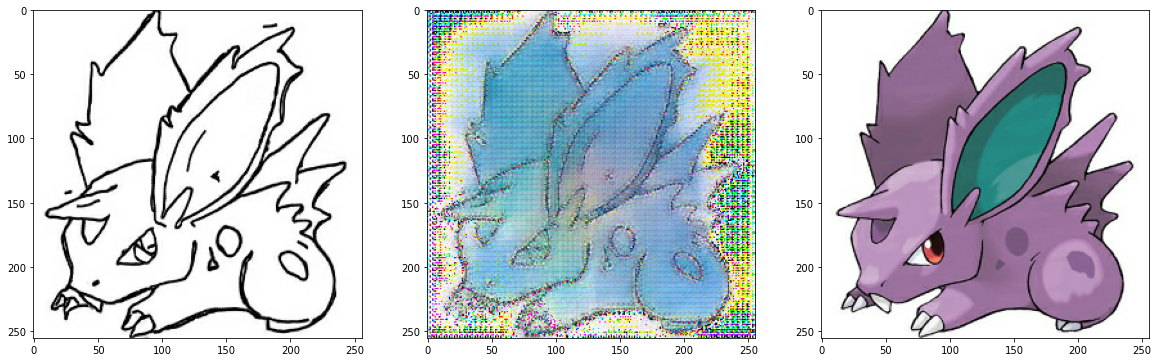

In [39]:
test_ind = 1

f = data_path + os.listdir(data_path)[test_ind]
sketch, colored = load_img(f)

pred = generator(tf.expand_dims(sketch, 0))
pred = denormalize(pred)

plt.figure(figsize=(20,10))
plt.subplot(1,3,1); plt.imshow(denormalize(sketch))
plt.subplot(1,3,2); plt.imshow(pred[0])
plt.subplot(1,3,3); plt.imshow(denormalize(colored))